# SATLAS

## Data Set-up

In [3]:
import os
import sys
ROOT = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(ROOT, 'src'))
from sen1floods11_dataset import Sen1Floods11Dataset, Sen1Floods11DataModule

import random
import torch

In [2]:
DATA_PATH = os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv')
datamodule = Sen1Floods11DataModule(DATA_PATH, 'HandLabeled', target='Flood', batch_size=8, num_workers=4,
                              debug=True, transforms=[], in_channels=3, expand=1, filter_data=True, normalize=True)
datamodule.setup()

In [15]:
def get_random_sample(train_loader):
    """
    Pick a random batch and then a random item from that batch.
    
    Args:
        train_loader (torch.utils.data.DataLoader): The training dataloader.
    
    Returns:
        tuple: (sample_img, sample_label, sample_otsu)
    """
    # Step 1: Pick a random batch
    num_batches = len(train_loader)
    rand_batch_idx = random.randint(0, num_batches - 1)

    for i, batch in enumerate(train_loader):
        if i == rand_batch_idx:
            rand_batch = batch
            break

    # Step 2: Pick a random item from that batch
    imgs = rand_batch['img']
    labels = rand_batch['label']   # adjust key if different
    otsu = rand_batch['otsu']

    rand_item_idx = torch.randint(0, imgs.shape[0], (1,)).item()
    sample_img = imgs[rand_item_idx]
    sample_label = labels[rand_item_idx]
    sample_otsu = otsu[rand_item_idx]

    return sample_img, sample_label, sample_otsu

def process_image(img_tensor):
    """
    Process a tensor image of shape (3, H, W) with values in [0, 255].
    
    Steps:
    - Keep only the first 2 channels.
    - Rescale values to [0, 1].
    - Add batch dimension -> (1, 2, H, W).
    
    Args:
        img_tensor (torch.Tensor): Input tensor of shape (3, H, W), values in [0, 255].
    
    Returns:
        torch.Tensor: Output tensor of shape (1, 2, H, W), values in [0, 1].
    """
    # Ensure input is float
    img_tensor = img_tensor.float()
    
    # Take first 2 channels
    img_tensor = img_tensor[:2, :, :]
    
    # Rescale to [0, 1]
    img_tensor = img_tensor / 255.0
    
    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)  # (1, 2, H, W)
    
    return img_tensor

train_loader = datamodule.train_dataloader()

img, label, otsu = get_random_sample(train_loader)
img = process_image(img)
print(img.shape)
print(label.shape)
print(otsu.shape)

torch.Size([1, 2, 512, 512])
torch.Size([512, 512])
torch.Size([512, 512])


## Using SATLAS

In [42]:
import satlaspretrain_models
import torch
weights_manager = satlaspretrain_models.Weights()

model = weights_manager.get_pretrained_model("Sentinel1_SwinB_SI", fpn=True, head=satlaspretrain_models.Head.SEGMENT, num_categories=2)

logits = model(img)[0]
output = torch.softmax(logits, dim=1)

In [54]:
output.shape

torch.Size([1, 2, 512, 512])

In [48]:
img[0][0].shape

torch.Size([512, 512])

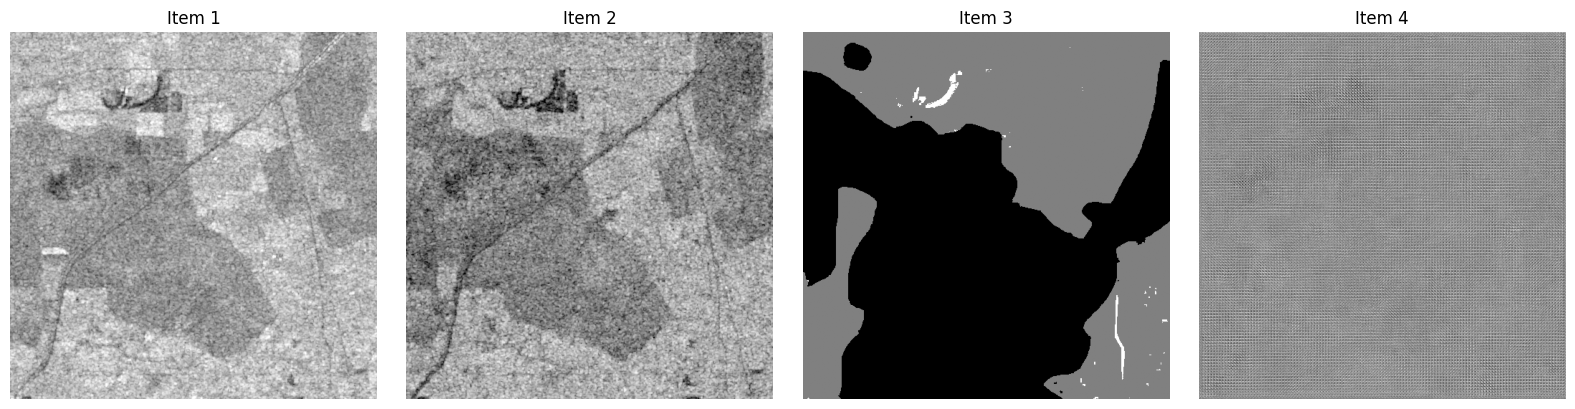

In [56]:
import matplotlib.pyplot as plt

def plot_tensor_list(tensor_list):
    """
    Plot each tensor in the list as a subplot.
    
    Args:
        tensor_list (list of torch.Tensor): Each tensor has shape (C, H, W).
            - C can be 1 (grayscale) or 3 (RGB).
    
    Returns:
        None (displays the plot).
    """
    num_items = len(tensor_list)
    fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 4))
    
    # If only one item, axes is not iterable
    if num_items == 1:
        axes = [axes]
    
    for i, tensor in enumerate(tensor_list):
        img = tensor.detach().cpu()
        
        # Convert (C, H, W) -> (H, W, C) for plotting
        if img.shape[0] == 1:
            img = img.squeeze(0)  # (H, W)
            axes[i].imshow(img, cmap="gray")
        else:
            img = img.permute(1, 2, 0)  # (H, W, C)
            axes[i].imshow(img)
        
        axes[i].axis("off")
        axes[i].set_title(f"Item {i+1}")
    
    plt.tight_layout()
    plt.show()

plot_tensor_list([
    img[0][0].unsqueeze(0),
    img[0][1].unsqueeze(0),
    label.unsqueeze(0),
    output[0][1].unsqueeze(0)
])